# Prepare notebook

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import string
from wordcloud import WordCloud
from plotting_utilities import *

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/acraig/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/acraig/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Import data

In [3]:
books = pd.read_pickle('20191128_goodreads_book_data.pkl')

In [4]:
len(books)

610

In [5]:
books.goodreads_description.count()

605

In [6]:
categories = pd.read_pickle('20191128_goodreads_book_categories.pkl')

In [7]:
len(categories.columns)

9

# Prepare textual data

In [8]:
alphanumeric_filter = re.compile('[\W_]+')
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()

books['filtered_description'] = books.goodreads_description.fillna('')\
                                    .map(lambda x: alphanumeric_filter.sub(' ', x).lower().strip())\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                if (token not in stop_words)]))

<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<>:1: DeprecationWarning: invalid escape sequence \W
<ipython-input-8-3501b7b04dcb>:1: DeprecationWarning: invalid escape sequence \W
  alphanumeric_filter = re.compile('[\W_]+')


In [9]:
books['description_nouns'] = books.filtered_description\
                                    .map(lambda text: ' '.join([wnl.lemmatize(token) for token in wpt.tokenize(text) 
                                                                if (nltk.pos_tag([token])[0][1] == 'NN')]))

In [10]:
books['filtered_doc_length'] = books.filtered_description.map(lambda text: len(text.split(' ')))
books['noun_length'] = books.description_nouns.map(lambda text: len(text.split(' ')))

 # Visualization

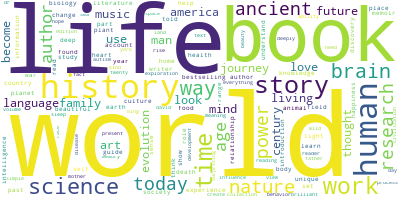

In [11]:
# Generate a word cloud based on all descriptions
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(','.join(list(books.filtered_description.values)))
wordcloud.to_image()

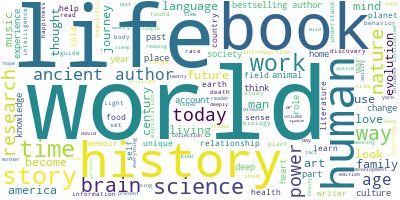

In [12]:
wordcloud.generate(','.join(list(books.description_nouns.values)))
wordcloud.to_image()

# Word counting methods

In [13]:
max_df=0.25
min_df=1
max_features=5000

field = 'description_nouns'

### Bag of words

In [14]:
# Fit and transform the descriptions
word_bag_cv = CountVectorizer(ngram_range=(1,1), max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                              stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'], binary= True)
word_bag_counts = word_bag_cv.fit_transform(books[field])

# Check against visualization
n = 5
counts = word_bag_counts.toarray().sum(axis = 0)
words = word_bag_cv.get_feature_names()
[words[i] for i in np.argpartition(counts, -n)[-n:]] 

['science', 'work', 'way', 'time', 'story']

### Bag of bigrams

In [15]:
# Fit and transform the descriptions
bigram_bag_cv = CountVectorizer(ngram_range=(2,2), max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                              stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'], binary= True)
bigram_bag_counts = bigram_bag_cv .fit_transform(books[field])

# Check against visualization
n = 5
counts = bigram_bag_counts.toarray().sum(axis = 0)
bigrams = bigram_bag_cv.get_feature_names()
[bigrams[i] for i in np.argpartition(counts, -n)[-n:]] 

['series oxford',
 'twenty century',
 'tell story',
 'human history',
 'pulitzer prize']

### TF-IDF 

In [16]:
tfidf_v = TfidfVectorizer(use_idf=True, max_df=max_df, min_df=min_df, 
                              #max_features=max_features,
                              stop_words=['new', 'york', 'times', 'bestselling', 
                                          'bestseller', 'award', 'winning', 'book'], binary= True)
tfidf_weights = tfidf_v.fit_transform(books[field])

# Check against visualization
n = 10
weights = tfidf_weights.toarray().sum(axis = 0)
weighted_words = tfidf_v.get_feature_names()
[weighted_words[i] for i in np.argpartition(weights, -n)[-n:]] 

['century',
 'today',
 'research',
 'nature',
 'author',
 'way',
 'science',
 'work',
 'story',
 'time']

# Topic Modeling

In [17]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [18]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 18

def print_top_words(model, feature_names, n_top_words = 10):
    for topic_idx, topic in enumerate(model.components_):
        message = " Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [19]:
# Fit the NMF model (Frobenius norm)
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (Frobenius norm):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (Frobenius norm):
 Topic #0: warlike wade route dawn section nothing reason humanity africa language
 Topic #1: pocket oxford combine enthusiasm area press analysis perfect subject university
 Topic #2: zulu fatal fate fateful fatewhy father fatherless fatigue faulkner fault
 Topic #3: wireless delivery purchase web format digital community edition faulkner fatigue
 Topic #4: infinity transform haidt unto enrich psychologist jonathan deeper kill zulu
 Topic #5: rica southwestern costa jack prolific interact wealth naturalist discover diverse
 Topic #6: hanh thich zen mindfulness master moment awake peacefulness guide orange
 Topic #7: wenk neuroscientific ignorance waste gary principle organ forget simplicity begin
 Topic #8: artifact domain concur entity base distribute copyright errant preservation etc
 Topic #9: zulu fatal fate fateful fatewhy father fatherless fatigue faulkner fault
 Topic #10: scarce artwork quality text commitment fauna fatalism fate fateful 

In [20]:
# Fit the NMF model (generalized Kullback-Leibler divergence)
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_weights)
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
print_top_words(nmf, tfidf_v.get_feature_names())


Topics in NMF model (generalized Kullback-Leibler divergence):
 Topic #0: author age century future way today power ancient look science
 Topic #1: evolution analysis introduction biology change area development perfect culture animal
 Topic #2: story america century edition family africa south nation man medieval
 Topic #3: brain science edition research dr digital daniel community work everything
 Topic #4: love compassion way work guide joy family action insight hope
 Topic #5: earth nature author biologist home deep living science diverse naturalist
 Topic #6: art literature collection greek master greece author ancient work volume
 Topic #7: journey story man found humor desert place memoir science heart
 Topic #8: body mind america relationship knowledge mental time work health brain
 Topic #9: civilization answer influence existence ancient crisis century half time millennium
 Topic #10: work part story novel way food read building planet biologist
 Topic #11: love family chang

In [21]:
# Fit LDA model 
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(word_bag_counts)
print("\nTopics in LDA model:")
print_top_words(lda, word_bag_cv.get_feature_names())


Topics in LDA model:
 Topic #0: edition community format story web delivery purchase digital wireless love
 Topic #1: presentsstory piglet waterstory heffalump woozlestory tight gamestory kanga poohpooh eeyorestory
 Topic #2: wise ancient origin duped susceptibility loki emerge blood pantheon fiction
 Topic #3: evolutionfor mckenna counterculture mind manifesto show university paperback superb civilization
 Topic #4: independence transform leila infinity philip wharton think prejudice willa montagu
 Topic #5: quality worcestershire request aprimer levitin cap distort separation award2011 infoliteracy
 Topic #6: gratification hone multiply innermost shake dean buonomano malfunction distrust faint
 Topic #7: flaubert faithful knight fielding chivalric quixote sagacity fancy playfulness panza
 Topic #8: protean wwi splendid arabia revolt amply turner participation arab warrior
 Topic #9: author beauty evolution time story earth change nature ellen brain
 Topic #10: netflix hit town despa

In [22]:
lda_data =  pyLDAvis.prepare(topic_term_dists = lda.components_, 
                             doc_topic_dists = lda.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

/Users/acraig/Desktop/python3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [23]:
%matplotlib inline

In [ ]:
# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid={'n_components': [10, 20, 40, 80], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [ 5, 10, 20, 40], 
                                    'max_iter': [10, 100, 1000]},
                        cv=3, n_jobs = -1, verbose = 1)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", model_lda.best_estimator_.score(word_bag_counts))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", model_lda.best_estimator_.perplexity(word_bag_counts))

# See model parameters
print(model_lda.get_params())

In [ ]:
pickle.dump(model_lda, open('gridsearchcv_lda.pkl', 'wb'))

In [ ]:
# model_lda = pickle.load(open('gridsearchcv_lda.pkl', 'rb'))

In [ ]:
results = pd.DataFrame(results['mean_test_score'], columns = ['mean_test_score']).join(
            pd.DataFrame(results['std_test_score'], columns = ['std_test_score']).join(
            pd.DataFrame(results['param_max_iter'].data, columns = ['max_iter']).join(
            pd.DataFrame(results['param_n_components'].data, columns = ['n_components']).join(
            pd.DataFrame(results['param_learning_decay'].data, columns = ['learning_decay']).join(
            pd.DataFrame(results['param_learning_offset'].data, columns = ['learning_offset']))))))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,8))

color_group_map = {10: 'Purples', 20: 'Reds', 40: 'Blues', 80:'Greens'}
learning_decay_map = {0.5: 0.25, 0.7: 0.5, 0.9:0.75}
learning_offset_map = {5:':', 10:'-.', 20:'--', 40:'-'}

for n_components, color_group in results.groupby('n_components'):
    cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
    for learning_decay, intensity_group in color_group.groupby('learning_decay'):
        color = cmap(learning_decay_map[learning_decay])
        for learning_offset, linestyle_group in intensity_group.groupby('learning_offset'):
            linestyle = learning_offset_map[learning_offset]
            linestyle_group = linestyle_group.sort_values('max_iter')
            
            ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_score'], 
                                      color = color, linestyle = linestyle, 
                                      label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
            ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                           y1 = linestyle_group['mean_test_score'] - 1.96*linestyle_group['std_test_score'],
                           y2 = linestyle_group['mean_test_score'] + 1.96*linestyle_group['std_test_score'],
                           color = color, alpha = 0.2)
ax.legend(title = '(n_components, learning_decay, learning_offset)', 
          ncol = 4, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)
        
ax.set_xscale('log')
ax.set_xlabel('number of iterations')
ax.set_ylabel('Log likelihood')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,8))

color_group_map = {10: 'Purples', 20: 'Reds', 40: 'Blues', 80:'Greens'}
learning_decay_map = {0.5: 0.25, 0.7: 0.5, 0.9:0.75}
learning_offset_map = {5:':', 10:'-.', 20:'--', 40:'-'}

n_components = 10
color_group = results.loc[results.n_components == n_components]
cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
for learning_decay, intensity_group in color_group.groupby('learning_decay'):
    color = cmap(learning_decay_map[learning_decay])
    for learning_offset, linestyle_group in intensity_group.groupby('learning_offset'):
        linestyle = learning_offset_map[learning_offset]
        linestyle_group = linestyle_group.sort_values('max_iter')

        ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_score'], 
                                  color = color, linestyle = linestyle, 
                                  label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
ax.legend(title = '(n_components, learning_decay, learning_offset)', 
          ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)
        
ax.set_xscale('log')
ax.set_xlabel('number of iterations')
ax.set_ylabel('Log likelihood')

In [ ]:
print("\nTopics in LDA model:")
print_top_words(model_lda.best_estimator_, word_bag_cv.get_feature_names())

In [ ]:
lda_data =  pyLDAvis.prepare(topic_term_dists = model_lda.best_estimator_.components_, 
                             doc_topic_dists = model_lda.best_estimator_.transform(word_bag_counts.toarray()), 
                             doc_lengths = books.filtered_doc_length.values,
                             vocab = word_bag_cv.get_feature_names(),
                             term_frequency = word_bag_counts.toarray().sum(axis = 0),
                             sort_topics=True)
pyLDAvis.display(lda_data)

In [24]:
from sklearn.metrics import log_loss, make_scorer, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

In [25]:
def custom_scorer_highest_topic_silhouette(estimator, X):
    X = X.toarray()
    return silhouette_score(X, np.argmax(estimator.transform(X), axis =1))
  
def custom_scorer_highest_topic_calinski_harabasz(estimator, X):
    X = X.toarray()
    return calinski_harabasz_score(X, np.argmax(estimator.transform(X), axis =1))


def custom_scorer_kmeans_silhouette(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return silhouette_score(X, labels)
  
def custom_scorer_kmeans_calinski_harabasz(estimator, X):
    X = X.toarray()
    kmeans_model = KMeans(n_clusters=estimator.n_components, random_state=1).fit(X)
    labels = kmeans_model.labels_
    return calinski_harabasz_score(X, labels)

def custom_scorer_log_likelihood(estimator, X):
    X = X.toarray()
    return estimator.score(X)

def custom_scorer_negative_perplexity(estimator, X):
    X = X.toarray()
    return -1*estimator.perplexity(X)


In [ ]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           'log_likelihood': custom_scorer_log_likelihood,
           'negative_perplexity': custom_scorer_negative_perplexity}

param_grid={'n_components': [10, 15, 20], 
                                    'learning_decay': [.5, .7, .9],
                                    'learning_offset': [20, 30, 40], 
                                    'max_iter': [50, 75, 100]}

# By default, scoring will be the LDA "score" method, which is log-likelihood
model_lda = GridSearchCV(LatentDirichletAllocation(),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'log_likelihood',
                        cv=3, n_jobs = -1, verbose = 2)
model_lda.fit(word_bag_counts)
results = model_lda.cv_results_

In [ ]:
pickle.dump(model_lda, open('gridsearchcv_lda_customScoring.pkl', 'wb'))

In [ ]:

results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_lda.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_lda.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_lda.cv_results_['param_'+param].data, columns = [param]))
    
for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {10: 'Purples', 15: 'Greens', 20: 'Blues'}
    learning_decay_map = {0.5: 0.25, 0.7: 0.5, 0.9:0.75}
    learning_offset_map = {20:':', 30:'-', 40:'--'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for learning_decay, intensity_group in color_group.groupby('learning_decay'):
            color = cmap(learning_decay_map[learning_decay])
            for learning_offset, linestyle_group in intensity_group.groupby('learning_offset'):
                linestyle = learning_offset_map[learning_offset]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, learning_decay, learning_offset)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)

In [ ]:
scoring = {'silhoutte_simple_cluster':custom_scorer_highest_topic_silhouette, 
           'silhoutte_kmeans_cluster': custom_scorer_kmeans_silhouette,
           'calinski_harabasz_simple_cluster':custom_scorer_highest_topic_calinski_harabasz, 
           'calinski_harabasz_kmeans_cluster': custom_scorer_kmeans_calinski_harabasz,
           #'log_likelihood': custom_scorer_log_likelihood,
           #'negative_perplexity': custom_scorer_negative_perplexity
          }

param_grid={'n_components': [4, 9, 18], 
                                    'alpha': [0.5, .1, .2, .4],
                                    'l1_ratio': [0.25,0.5,0.75], 
                                    'max_iter': [50, 75, 100]}

# By default, scoring will be the LDA "score" method, which is log-likelihood
model_nmf = GridSearchCV(NMF(beta_loss='kullback-leibler', solver='mu'),
                        param_grid=param_grid,
                         scoring = scoring, refit = 'silhoutte_kmeans_cluster',
                        cv=3, n_jobs = -1, verbose = 2)
model_nmf.fit(tfidf_weights)
results = model_nmf.cv_results_

pickle.dump(model_nmf, open('gridsearchcv_nmf_customScoring.pkl', 'wb'))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.8min


In [ ]:
results = None

for score in scoring.keys():
    if results is None:
        results = pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score])\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
    else:
        results = results.join(pd.DataFrame(model_nmf.cv_results_['mean_test_'+score], columns = ['mean_test_'+score]))\
                     .join(pd.DataFrame(model_nmf.cv_results_['std_test_'+score], columns = ['std_test_'+score]))
for param in param_grid.keys():
    results = results.join(pd.DataFrame(model_nmf.cv_results_['param_'+param].data, columns = [param]))

for score in scoring.keys():
    fig, ax = plt.subplots(1,1, figsize = (20,8))
    fig.suptitle(score)
    
    color_group_map = {4: 'Purples', 9: 'Greens', 18: 'Blues'}
    l1_ratio_map = {0.25: 0.25, 0.5: 0.5, 0.75:0.75}
    alpha_map = {0.5:':', 0.1:'-.', 0.2:'--',0.4:'-'}

    for n_components, color_group in results.groupby('n_components'):
        cmap = matplotlib.cm.get_cmap(color_group_map[n_components])
        for l1_ratio, intensity_group in color_group.groupby('l1_ratio'):
            color = cmap(l1_ratio_map[l1_ratio])
            for alpha, linestyle_group in intensity_group.groupby('alpha'):
                linestyle = alpha_map[alpha]
                linestyle_group = linestyle_group.sort_values('max_iter')

                ax.plot(linestyle_group['max_iter'], linestyle_group['mean_test_'+score], 
                                          color = color, linestyle = linestyle, 
                                          label = '(%d, %.1f, %d)'%(n_components, learning_decay, learning_offset))
                ax.fill_between(x = linestyle_group['max_iter'].astype(float), 
                               y1 = linestyle_group['mean_test_'+score] - 1.96*linestyle_group['std_test_'+score],
                               y2 = linestyle_group['mean_test_'+score] + 1.96*linestyle_group['std_test_'+score],
                               color = color, alpha = 0.2)
    ax.legend(title = '(n_components, l1_ratio, alpha)', 
              ncol = 3, bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.)

    ax.set_xscale('log')
    ax.set_xlabel('number of iterations')
    ax.set_ylabel(score)